**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

# План заданий

Итак, вот, что от вас требуется в этом задании:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

**P.S. Не забывайте сохранять модели после обучения**

#Модель

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.utils.data import DataLoader
import math
import pandas as pd
import os
from torch.utils.data import Dataset
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

In [2]:
# Код для сортировки изображений, чтобы использовались только те ID, что есть в датасете
idf_path = "D:\\dlsPart2\\identity_CelebA3.txt"
img_folder = "D:\\dlsPart2\\Aligned_Images3"

identity_df = pd.read_csv(idf_path, sep=' ', header=None, names=['filename', 'person_id'])

files = set(os.listdir(img_folder))

filtered_df = identity_df[identity_df['filename'].isin(files)]

num_people = filtered_df['person_id'].nunique()

stats = {
    'total_images': len(filtered_df),
    'unique_people': num_people,
    'images_per_person': filtered_df['person_id'].value_counts().describe().to_dict()
}
print(stats)

{'total_images': 20000, 'unique_people': 956, 'images_per_person': {'count': 956.0, 'mean': 20.92050209205021, 'std': 1.5626391151459447, 'min': 3.0, '25%': 20.0, '50%': 21.0, '75%': 22.0, 'max': 27.0}}


In [3]:
class CelebDataset(Dataset):
    def __init__(self, img_folder, identity_data, id_to_label, training=True):
        
        self.img_folder = img_folder
        self.identity_df = identity_data
        self.training = training

        # Фильтрация (оставляем на всякий случай)
        files = set(os.listdir(img_folder))
        self.identity_df = self.identity_df[self.identity_df['filename'].isin(files)]

        self.id_to_label = id_to_label

        self.img_paths = self.identity_df['filename'].tolist()
        # Применяем единый словарь для получения меток
        self.labels = self.identity_df['person_id'].map(self.id_to_label).tolist()

        self.train_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),  # Отражение по горизонтали
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Сдвиги и масштабирование
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Цветовые изменения
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация для ImageNet
        ])

        self.val_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_paths[idx])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Ошибка загрузки: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.train_transforms(image) if self.training else self.val_transforms(image)

        label = self.labels[idx]
        return image, label

In [4]:
import torchvision.models as models

num_classes = num_people
model = models.resnet50(pretrained=True) # Возьмем resnet50, тк в статье была именно она
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():  # Размораживаем только верхний блок
    param.requires_grad = True
model.fc = nn.Sequential(
    nn.Dropout(p=0.60), # Типичное значение во время обучения 0.5, в конце повысил, чтобы приподнять val_acc
    nn.Linear(model.fc.in_features, num_classes)  # Полносвязный слой для классификации
)
model = model.cuda()

c:\Users\odron\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\odron\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def train(model, train_dataset, val_dataset, epochs=50, batch_size=32, lr=0.001,
          device='cuda', savepath="model.pth", pre_train=None):

    if pre_train is not None:
        model.load_state_dict(torch.load(pre_train))
        print(f"Загружены предобученные веса из {pre_train}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    #optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=2e-4) # Основой оптимайзер
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4) # для добивочки :)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=3) # Помогал, но часто приходилось руками делать
    criterion = nn.CrossEntropyLoss()

    model = model.to(device)
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'best_val_loss': float('inf'),
        'best_val_acc': 0.0
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': f"{100 * correct / total:.2f}%",
                'lr': optimizer.param_groups[0]['lr']
            })

        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = 100 * correct / total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Применим TTA, чтобы дообучить модель до 70%, а то она зависла на 69...
                # Идея в том, чтобы для каждой картинки в валидационном сете делать предсказание не только для оригинала, но и для его аугментированной версии, а потом усреднять.
                outputs_original = model(images)
                flipped_images = torch.flip(images, [3])
                outputs_flipped = model(flipped_images)
                outputs = (torch.softmax(outputs_original, dim=1) + torch.softmax(outputs_flipped, dim=1)) / 2
                loss = criterion(torch.log(outputs), labels) 

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = 100 * val_correct / val_total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        scheduler.step(epoch_val_loss)

        if epoch_val_acc > history['best_val_acc']:
            history['best_val_acc'] = epoch_val_acc
            history['best_val_loss'] = epoch_val_loss
            torch.save(model.state_dict(), savepath)
            print(f"Модель сохранена с val_acc: {epoch_val_acc:.2f}%")

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    return model, history

In [ ]:
# Функция для разделения данных с сохранением классов
# Сделана, тк изначально сети было сложно обучаться, тк картинки человека могли быть в треине, но их не было в вал выборке
def split_by_person(df, test_size=0.2, random_state=42):
    train_dfs = []
    val_dfs = []

    for person_id in df['person_id'].unique():
        person_data = df[df['person_id'] == person_id]
        if len(person_data) < 2:  # Пропустить классы с 1 изображением
            continue
        # Разделение изображений одного человека
        train_person, val_person = train_test_split(
            person_data, test_size=test_size, random_state=42
        )
        train_dfs.append(train_person)
        val_dfs.append(val_person)

    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)

    return train_df, val_df

train_df, val_df = split_by_person(filtered_df, test_size=0.20, random_state=42)

# Создаем единый словарь для всех данных, которые будут использоваться
all_used_ids = pd.concat([train_df, val_df])['person_id'].unique()
id_to_label_map = {id_val: i for i, id_val in enumerate(all_used_ids)}

num_classes_actual = len(id_to_label_map) 
print(f"Фактическое количество классов для обучения: {num_classes_actual}")

# Проверка, что классы совпадают
train_classes = set(train_df['person_id'].unique())
val_classes = set(val_df['person_id'].unique())
print(f"Number of unique classes in train: {len(train_classes)}")
print(f"Number of unique classes in val: {len(val_classes)}")
print(f"Classes in val but not in train: {len(val_classes - train_classes)}")
print(f"Classes in train but not in val: {len(train_classes - val_classes)}")

#Проверка баланса классов
print("\nTrain dataset class distribution:")
print(train_df['person_id'].value_counts().describe())
print("\nValidation dataset class distribution:")
print(val_df['person_id'].value_counts().describe())

Фактическое количество классов для обучения: 956
Number of unique classes in train: 956
Number of unique classes in val: 956
Classes in val but not in train: 0
Classes in train but not in val: 0

Train dataset class distribution:
count    956.000000
mean      16.375523
std        1.177533
min        2.000000
25%       16.000000
50%       16.000000
75%       17.000000
max       21.000000
Name: count, dtype: float64

Validation dataset class distribution:
count    956.000000
mean       4.544979
std        0.522846
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        6.000000
Name: count, dtype: float64


In [7]:
idf_path = "D:\\dlsPart2\\identity_CelebA3.txt"
img_folder = "D:\\dlsPart2\\Aligned_Images3"

train_dataset = CelebDataset(img_folder, train_df, id_to_label_map, training=True)
val_dataset = CelebDataset(img_folder, val_df, id_to_label_map, training=False)

C:\Users\odron\AppData\Local\Temp\ipykernel_24928\3096948869.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pre_train))


Загружены предобученные веса из best_resnet50VBEST.pth


Epoch 1/10: 100%|██████████| 245/245 [02:49<00:00,  1.45it/s, loss=0.0574, acc=99.23%, lr=1e-6]


Модель сохранена с val_acc: 71.62%
Epoch 1/10 | Train Loss: 0.0629 | Val Loss: 1.3902 | Train Acc: 99.23% | Val Acc: 71.62%


Epoch 2/10: 100%|██████████| 245/245 [01:57<00:00,  2.08it/s, loss=0.0899, acc=99.37%, lr=1e-6]


Модель сохранена с val_acc: 71.76%
Epoch 2/10 | Train Loss: 0.0583 | Val Loss: 1.3805 | Train Acc: 99.37% | Val Acc: 71.76%


Epoch 3/10: 100%|██████████| 245/245 [01:59<00:00,  2.05it/s, loss=0.0317, acc=99.26%, lr=1e-6]


Epoch 3/10 | Train Loss: 0.0619 | Val Loss: 1.3937 | Train Acc: 99.26% | Val Acc: 71.42%


Epoch 4/10: 100%|██████████| 245/245 [01:59<00:00,  2.06it/s, loss=0.0243, acc=99.29%, lr=1e-6]


Epoch 4/10 | Train Loss: 0.0611 | Val Loss: 1.3895 | Train Acc: 99.29% | Val Acc: 71.48%


Epoch 5/10: 100%|██████████| 245/245 [01:58<00:00,  2.06it/s, loss=0.0745, acc=99.34%, lr=1e-6]


Epoch 5/10 | Train Loss: 0.0607 | Val Loss: 1.3853 | Train Acc: 99.34% | Val Acc: 71.65%


Epoch 6/10: 100%|██████████| 245/245 [02:01<00:00,  2.01it/s, loss=0.0756, acc=99.17%, lr=1e-6]


Epoch 6/10 | Train Loss: 0.0619 | Val Loss: 1.3899 | Train Acc: 99.17% | Val Acc: 71.74%


Epoch 7/10: 100%|██████████| 245/245 [02:05<00:00,  1.95it/s, loss=0.0723, acc=99.30%, lr=6e-7]


Epoch 7/10 | Train Loss: 0.0611 | Val Loss: 1.3823 | Train Acc: 99.30% | Val Acc: 71.60%


Epoch 8/10: 100%|██████████| 245/245 [02:01<00:00,  2.01it/s, loss=0.039, acc=99.28%, lr=6e-7] 


Epoch 8/10 | Train Loss: 0.0607 | Val Loss: 1.3919 | Train Acc: 99.28% | Val Acc: 71.53%


Epoch 9/10: 100%|██████████| 245/245 [02:02<00:00,  2.00it/s, loss=0.106, acc=99.25%, lr=6e-7] 


Epoch 9/10 | Train Loss: 0.0621 | Val Loss: 1.3934 | Train Acc: 99.25% | Val Acc: 71.58%


Epoch 10/10: 100%|██████████| 245/245 [02:28<00:00,  1.65it/s, loss=0.0508, acc=99.27%, lr=6e-7]


Epoch 10/10 | Train Loss: 0.0596 | Val Loss: 1.3864 | Train Acc: 99.27% | Val Acc: 71.74%


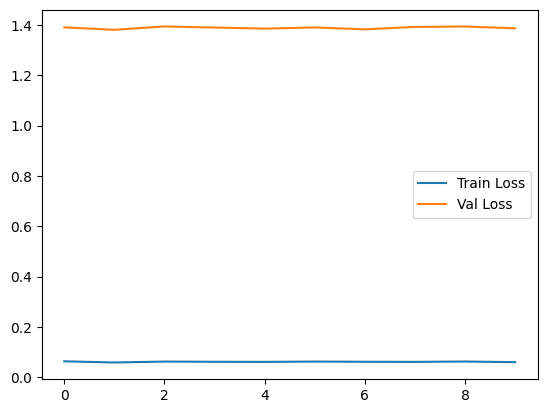

In [ ]:
#train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Обучалось в сумме эпох 80+-
trained_model, history = train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=10,
    batch_size=64,
    lr=1e-6,
    device='cuda',
    savepath='best_resnet50VBEST2.pth',
    pre_train = 'best_resnet50VBEST.pth',
)

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:

# Код для создания нового датасета, чтобы он включал в себя макс кол-во людей с наибольшим кол-вом картинок. Было сделано на 10к 20к и 30к


import shutil

idf_path = "D:\\dlsPart2\\identity_CelebA.txt"
img_folder = "D:\\dlsPart2\\img_align_celeba\\"
output_folder = "D:\\dlsPart2\\img_align_celeba4\\" # Новая папка для отфильтрованных изображений
output_idf_path = "D:\\dlsPart2\\identity_CelebA4.txt"  # Новый файл меток

# Целевой размер
target_dataset_size = 20000

os.makedirs(output_folder, exist_ok=True)
identity_df = pd.read_csv(idf_path, sep=' ', header=None, names=['filename', 'person_id'])
files = set(os.listdir(img_folder))
filtered_df = identity_df[identity_df['filename'].isin(files)]

#сортировка по убыванию
person_counts = filtered_df['person_id'].value_counts().sort_values(ascending=False)

selected_images = []
current_size = 0
selected_persons = []

for person_id in person_counts.index:
    person_data = filtered_df[filtered_df['person_id'] == person_id]
    if current_size + len(person_data) <= target_dataset_size:
        selected_images.append(person_data)
        current_size += len(person_data)
        selected_persons.append(person_id)
    else:
        remaining = target_dataset_size - current_size
        selected_images.append(person_data.sample(n=remaining, random_state=42))
        selected_persons.append(person_id)
        break

filtered_df = pd.concat(selected_images, ignore_index=True)

for _, row in filtered_df.iterrows():
    src_path = os.path.join(img_folder, row['filename'])
    dst_path = os.path.join(output_folder, row['filename'])
    try:
        shutil.copy(src_path, dst_path)
    except FileNotFoundError:
        print(f"Файл не найден: {src_path}")
        continue

# Сохранение нового файла меток
filtered_df.to_csv(output_idf_path, sep=' ', header=False, index=False)

stats = {
    'total_images': len(filtered_df),
    'unique_people': filtered_df['person_id'].nunique(),
    'images_per_person': filtered_df['person_id'].value_counts().describe().to_dict()
}
print("Статистика отфильтрованного датасета:")
print(stats)

Статистика отфильтрованного датасета:
{'total_images': 20000, 'unique_people': 956, 'images_per_person': {'count': 956.0, 'mean': 20.92050209205021, 'std': 1.5626391151459447, 'min': 3.0, '25%': 20.0, '50%': 21.0, '75%': 22.0, 'max': 27.0}}
